In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
import time
import utils.dsp
import utils.phantom
import utils.opt
from recon.TV_FISTA import tvdeblur

# get device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available!")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("CUDA unavailable - using CPU")
    device = torch.device("cpu")

CUDA is available!
GPU: NVIDIA GeForce RTX 2080 Ti
CUDA version: 12.1
Number of GPUs: 4


/tmp/ipykernel_47861/1402723450.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p = torch.tensor(p, dtype=torch.complex64, device=device)


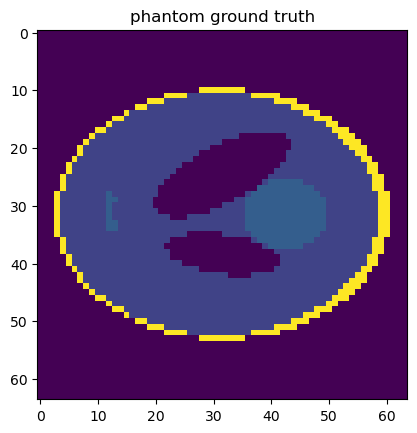

In [2]:
# generate phantom
N = 64
p = utils.phantom.phantom3d((N,N,1)).squeeze()
p = torch.tensor(p, dtype=torch.complex64, device=device)
plt.figure(0)
plt.imshow(np.absolute(p.cpu().numpy()))
plt.title('phantom ground truth')
plt.show()

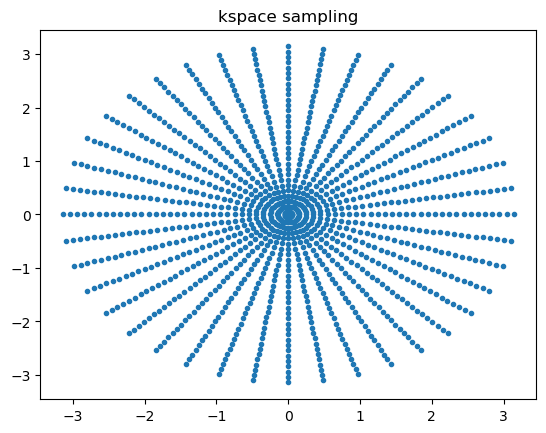

In [3]:
# generate radial kspace trajectory
kspoke = np.stack((np.linspace(-np.pi,np.pi,N),np.zeros((N))),axis=0)
nspokes = 20 # fully sampled in-plane is pi*N

for i in range(0,nspokes):
    theta = np.pi*i/nspokes
    R = [[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]
    kspokei = np.matmul(R,kspoke)
    if i == 0:
        klocs = kspokei
    else:
        klocs = np.concatenate((klocs,kspokei),axis=1)

plt.figure(0)
plt.plot(klocs[0,:],klocs[1,:],'.')
plt.title('kspace sampling')
plt.show()

klocs = torch.tensor(klocs, dtype=torch.float, device=device)

/home/djfrey/tvrec/utils/phantom.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(smaps,dtype=torch.complex128)
/tmp/ipykernel_47861/3481270005.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smaps = torch.tensor(smaps, dtype=torch.complex64, device=device)


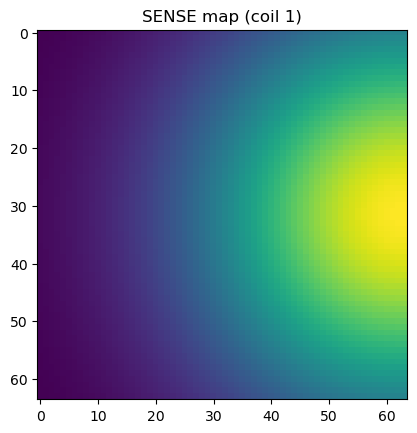

In [4]:
# create the nufft object and define fwd/adj operators
nufft_ob = tkbn.KbNufft(im_size=(N,N),device=device)
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=(N,N),device=device)

smaps = utils.phantom.simsmaps((N,N,1)).squeeze().unsqueeze(0)
smaps = torch.tensor(smaps, dtype=torch.complex64, device=device)

A_fwd = lambda x: nufft_ob(x,klocs,smaps=smaps)
A_adj = lambda b: adjnufft_ob(b,klocs,smaps=smaps)

# show a sense map
plt.figure(0)
plt.imshow(np.absolute(smaps[0,0,:,:].squeeze().cpu().numpy()))
plt.title('SENSE map (coil 1)')
plt.show()

time to compute Ax: 0.195870s
time to compute ATb: 0.776013s


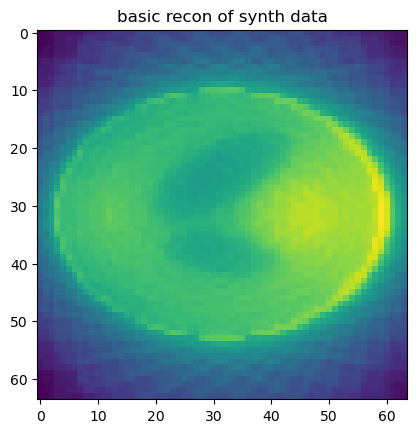

In [5]:
# synthesize kspace data and show basic recon
t0 = time.time()
kdata = A_fwd(p.unsqueeze(0).unsqueeze(0))
t1 = time.time()
print('time to compute Ax: %fs' % (t1-t0))

t0 = time.time()
tmp = A_adj(kdata)
t1 = time.time()
print('time to compute ATb: %fs' % (t1-t0))

plt.figure(0)
plt.imshow(np.absolute(A_adj(kdata).squeeze().cpu().numpy()))
plt.title('basic recon of synth data')
plt.show()

In [6]:
# estimate the Lipschitz constant using power iteration
L = utils.opt.pwritr(A_fwd,A_adj,p.unsqueeze(0).unsqueeze(0))
print(L)

tensor(12510.1533, device='cuda:0')


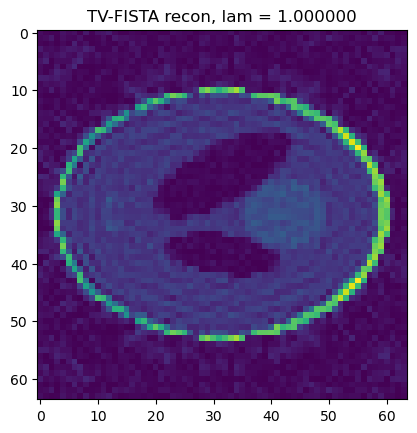

In [7]:
# recon the image
lam = 1
niter = 300
x_star, x_set = tvdeblur(A_fwd, A_adj, kdata, lam=lam, niter=niter, L=L)

plt.figure(0)
plt.imshow(np.absolute(x_star.squeeze().cpu().numpy()))
plt.title('TV-FISTA recon, lam = %f' % lam)
plt.show()